# **Infer `Golgi`**

***Prior to this notebook, you should have already run through [1.0_image_setup](1.0_image_setup.ipynb).***

In notebooks 1.2 through 1.7, we will go over the implementation of `infer-subc` in the a Napari plugin called  `organelle-segmenter-plugin`. The steps outlined in each notebook correlate to the workflow steps from the plugin. Here, you will gain knowledge of what `infer-subc` functions are involved in each of those steps.

The segmentation workflows are completely independent of each other and can be run in any order. The current notebook segments the `Golgi`. Notesbook for the segmentation of other organelles can be found here:
- Infer [`lysosomes`](1.2_infer_lysosome.ipynb)
- Infer [`mitochondria`](1.3_infer_mitochondria.ipynb)
- Infer [`peroxisomes`](1.5_infer_peroxisome.ipynb)
- Infer [`endoplasmic reticulum (ER)`](1.6_infer_ER.ipynb)
- Infer [`lipid droplets`](1.7_infer_lipid_droplet.ipynb)

***Note:** These notebooks do not include a batch processing option. They are simply explanations of the steps included in the Napari plugin. If you would like to batch process your images in a Jupyter notebook instead of the plugin, you can use the [batch process segmentation](batch_process_segmentations.ipynb) notebook.*

### **Single cell analysis**
Each workflow segments organelles from the entire image, irrespective of the cell mask identified in notebook 1.1. To attain a single-cell analysis, the mask will be applied to the organelle segmentation outputs before quantification in the `part_2_quantification` notebooks. 

### **Golgi** 📦✉️
The Golgi is a membrane-enclosed complex that is part of the secretory pathway. Proteins and lipids are synthesized in the endoplasmic reticulum (ER), transferred to the Golgi where they are modified as needed, and then packaged into vesicles for further transport throughout the cell. The Golgi also acts as a signaling hub for nutrient sensing, cell growth and metabolism, and is involved in organelle contacts with other membrane-bound organelles. 

### **Fluorescence labeling strategies** 🔆 
The Golgi can be fluorescently labeled in live and fixed cells by staining for endogenous proteins, targeting fluorescent proteins to the membrane or lumen using genertically encoded markers, or with dye-based approaches. The labeling approach used and resolution of your images can result in different staining outcomes that can impact the segmentation steps below. Additionally, sub-compartments within the Golgi have differing resident proteins making genetic and immunolabeling approaches nuanced. For example, labeling the GM130 protein will target the cis-Golgi while p230 will target the trans-Golgi network. These structures will likely have slightly different characteristics.

This workflow was optimized for images of fluorescently tagged sialyltransferase 1 (SiT1), a Golgi membrane protein. The resulting Golgi structure has both the classical cisternae as well as small Golgi-derived vesicles; so we are utilizing two segmentation methods to idenfity the entire Golgi structure.

***We advise that you test the segmentation process on a small, pilot dataset before committing to a particular labeling strategy and segmentation approach.***

-----

### 👣 **Summary of steps**  

➡️ **EXTRACTION**
- **`STEP 1`** - Select a channel for segmentation

    - select single channel containing the golgi marker (channel number = user input)

**PRE-PROCESSING**
- **`STEP 2`** - Rescale and smooth image

  - rescale intensity of composite image (min=0, max=1)
  - median filter (median size = user input)
  - gaussian filter (sigma = user input)

**CORE PROCESSING**
- **`STEP 3`** - Global + local thresholding (AICSSeg – MO)

    - apply MO thresholding method from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (threshold options = user input)

- **`STEP 4`** - Thin segmentation (Topology preserving)

    - apply topology preserved thinning function from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (thinning amount, minimum thickness = user input)

- **`STEP 5`** - ‘Dot’ thresholding method (AICSSeg)

    - apply "dot" thresholding method (for small round objects) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (size scale and threshold cutoff = user input)

- **`STEP 6`** - Combine Segmentations (logical or)

    - combine the two segmentations with logical *OR*

**POST-PROCESSING**
- **`STEP 7`** - Remove small holes and objects

  - fill holes (hole size = user input)
  - remove small objects (object size = user input)
  - filter method (method = user input)

**POST-POST-PROCESSING**
- **`STEP 8`** - Label objects

  - label unique golgi objects based on connectivity

**EXPORT** ➡️
- save labeled ***golgi*** (golgi, GL) as unsigned integer 16-bit tif files


*This workflow is an adaptation of the Allen Cell Segmenter procedure for segmentation of Golgi from the [sialyltransferase 1 (ST6GAL1)](https://www.allencell.org/cell-observations/category/golgi-apparatus) marker. Sourced from: this [script](https://github.com/AllenCell/aics-segmentation/blob/main/aicssegmentation/structure_wrapper/seg_st6gal1.py).*

---------------------
## **IMPORTS AND LOAD IMAGE**
Details about the functions included in this subsection are outlined in the [`1.0_image_setup`](1.0_image_setup.ipynb) notebook. Please visit that notebook first if you are confused about any of the code included here.

#### &#x1F3C3; **Run code; no user input required**

In [1]:
from pathlib import Path
import os

import numpy as np
import pandas as pd
import napari
from napari.utils.notebook_display import nbscreenshot

from aicssegmentation.core.utils import topology_preserving_thinning

from infer_subc.core.file_io import (read_czi_image,
                                     export_inferred_organelle,
                                     list_image_files,
                                     sample_input)
from infer_subc.core.img import *

%load_ext autoreload
%autoreload 2

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following information about your data: `im_type`, `data_root_path`, `in_data_path`, and `out_data_path`.

In [2]:
### USER INPUT REQUIRED ###
# If using the sample data, select which cell type you would like analyze ("neuron_1", "astrocyte", "neuron_2" or "ipsc"):
# If not using the sample data, set cell_type to None
sample_data_type = "neuron_1"

# If you are not using the sample data, please edit "USER SPECIFIED" as necessary.
## Define the path to the directory that contains the input image folder.
data_root_path = Path("USER SPECIFIED")

# Specify the file type of your raw data that will be analyzed. Ex) ".czi" or ".tiff"
im_type = "USER SPECIFIED"

## Specify which subfolder that contains the input data and the input data file extension
in_data_path = data_root_path / "USER SPECIFIED"

## Specify the output folder to save the segmentation outputs if.
## If its not already created, the code below will creat it for you
out_data_path = data_root_path / "USER SPECIFIED"

#### &#x1F3C3; **Run code; no user input required**

In [3]:
# If sample_data_type is set to "neuron_1", "astrocyte", "neuron_2" or "ipsc", then the sample data is used and the directories are set
if sample_data_type != None:
    data_root_path, im_type, in_data_path, out_data_path = sample_input(sample_data_type)

# list files in the input folder
img_file_list = list_image_files(in_data_path,im_type)
pd.set_option('display.max_colwidth', None)
pd.DataFrame({"Image Name":img_file_list})

,Image Name
0,c:\Users\redre\Documents\CohenLab\scohen_lab_repo\infer-subc\sample_data\example_neuron_1\raw\20230727_C2-121_conditioned_well 4_cell 1_untreated_Linear unmixing_0_cmle.ome.tiff


#### &#x1F6D1; &#x270D; **User Input Required:**

Use the list above to specify which image you wish to analyze based on its index: `test_img_n`

In [4]:
#### USER INPUT REQUIRED ###
test_img_n = 0

#### &#x1F3C3; **Run code; no user input required**

In [5]:
# load image and metadata
test_img_name = img_file_list[test_img_n]
img_data,meta_dict = read_czi_image(test_img_name)

# metadata
channel_names = meta_dict['name']
meta = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']
file_path = meta_dict['file_name']
print("Metadata information")
print(f"File path: {file_path}")
for i in list(range(len(channel_names))):
    print(f"Channel {i} name: {channel_names[i]}")
print(f"Scale (ZYX): {scale}")
print(f"Channel axis: {channel_axis}")

# open viewer and add images
viewer = napari.Viewer()
for i in list(range(len(channel_names))):
    viewer.add_image(img_data[i],
                     scale=scale,
                     name=f"Channel {i}")
viewer.grid.enabled = True
viewer.reset_view()
print("\nProceed to Napari window to view your selected image.")

Metadata information
File path: c:\Users\redre\Documents\CohenLab\scohen_lab_repo\infer-subc\sample_data\example_neuron_1\raw\20230727_C2-121_conditioned_well 4_cell 1_untreated_Linear unmixing_0_cmle.ome.tiff
Channel 0 name: 20230727_C2-121_conditioned_well 4_cell 1_untreated_Linear unmixing_0_cmle.ome :: Channel:0
Channel 1 name: 20230727_C2-121_conditioned_well 4_cell 1_untreated_Linear unmixing_0_cmle.ome :: Channel:1
Channel 2 name: 20230727_C2-121_conditioned_well 4_cell 1_untreated_Linear unmixing_0_cmle.ome :: Channel:2
Channel 3 name: 20230727_C2-121_conditioned_well 4_cell 1_untreated_Linear unmixing_0_cmle.ome :: Channel:3
Channel 4 name: 20230727_C2-121_conditioned_well 4_cell 1_untreated_Linear unmixing_0_cmle.ome :: Channel:4
Channel 5 name: 20230727_C2-121_conditioned_well 4_cell 1_untreated_Linear unmixing_0_cmle.ome :: Channel:5
Scale (ZYX): (0.410594, 0.079947, 0.079947)
Channel axis: 0

Proceed to Napari window to view your selected image.


-----

## **EXTRACTION**

### **`STEP 1` - Select a channel for segmentation**

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify which channel includes your Golgi label:
- `GOLGI_CH`: the index of the channel containing your Golgi label. Image indexing begins with 0, not 1. Reference the channel numbers indicated in the Napari window for easy reference.

⚙️ **SAMPLE DATA SETTINGS**

If using the sample data, here are the correct channel indices

|**Cell type**|GOLGI_CH| 
| :------------------------------------- |  :------:  |
|Neuron 1|`2`|
|Astrocyte|`2`|
|Neuron 2|`2`|
|IPSC|`4`|

In [6]:
#### USER INPUT REQUIRED ###
GOLGI_CH = 2

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block extracts the Golgi channel from your multi- (or single) channel image. It will be the only part of the image used in the rest of this workflow. The single golgi channel is added to the Napari viewer.

In [7]:
# select channel
raw_golgi = select_channel_from_raw(img_data, GOLGI_CH)

# clear napari and add single channel as a new layer
viewer.layers.clear()
viewer.grid.enabled = False
viewer.add_image(raw_golgi, scale=scale, name="1 - Extract Golgi")

<Image layer '1 - Extract Golgi' at 0x1ceb2b6cb20>

-----
## **PRE-PROCESSING**

### **`STEP 2` - Rescale and smooth image**

&#x1F453; **FYI:** This code block rescales the image so that the pixel/voxel with the highest intensity is set to 1 and the one with the lowest intensity is set to 0. The image is then *optionally* smoothed using a Gaussian and/or median filter. 

<mark> Include more information on the Gaussian and median filtering methods here </mark>

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the amount of filter to use for each method. Higher values indicate more smoothing:
- `med_filter_size`: the size of the median filter to apply; if 0 is used, no filter will be applied
- `gaussian_smoothing_sigma`: the sigma to apply in the Gaussian filtering step; if 0 is used, no filter will be applied

⚙️ **SAMPLE DATA SETTINGS**

If using the sample data, here are the recommended parameters for each cell type

|**Cell type**|med_filter_size|gaussian_smoothing_sigma| 
| :------------------------------------- |  :------:  |  :------:  |
|Neuron 1|`0`|`0.0`|
|Astrocyte|`0`|`0.0`|
|Neuron 2|`0`|`0.0`|
|IPSC|`0`|`0.0`|

In [8]:
#### USER INPUT REQUIRED ###
median_sz = 0
gauss_sig = 0.0

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block rescales the image and applies the specified median and Gaussian filters. The image is then added to Napari as a new layer for visual comparison to the input image. 

Use the Napari viewer to iteratively adjust the smoothing settings selected above.

In [9]:
# rescaling and smoothing input image
struct_img =  scale_and_smooth(raw_golgi,
                               median_size = median_sz, 
                               gauss_sigma = gauss_sig)

# adding image to Napari as a new layer
viewer.add_image(struct_img, scale=scale, name="2 - Rescale and Smooth")

<Image layer '2 - Rescale and Smooth' at 0x1ceb9222590>

-----
## **CORE-PROCESSING**

### **`STEP 3` - Global + local thresholding (AICSSeg – MO)**

&#x1F453; **FYI:** This code block is the first of two semantic segmentation steps that are combined together in a later step, and is used to segment Golgi cisterae strucutres. `Semantic segmentation` is the process of deciding whether a pixel/voxel should be included in an object (labeled with a value of 1) or should be considered as part of the background (labeled with a value of 0). A semantic segmentation does not discern individual objects from one another.

The masked_object_filter utilizes the 'MO' filter from the [`aics-segmentation`](https://github.com/AllenCell/aics-segmentation) package. AICS documentation states: "The algorithm is a hybrid thresholding method combining two levels of thresholds. The steps are: [1] a global threshold is calculated, [2] extract each individual connected componet after applying the global threshold, [3] remove small objects, [4] within each remaining object, a local Otsu threshold is calculated and applied with an optional local threshold adjustment ratio (to make the segmentation more and less conservative). An extra check can be used in step [4], which requires the local Otsu threshold larger than 1/3 of global Otsu threhsold and otherwise this connected component is discarded."

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `thresh_method`: the global thresholding method; options include 'tri'/'triangle, 'med'/'median' or 'ave'/'ave_tri_med'. Triangle implements the [skimage.filters.threshold_triangle](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.threshold_triangle) method, median utilizes the 50th percentile of the intensities, and ave uses the average of the two methods to calculate the lower bound of the global threshold.
- `cell_wise_min_area`: the minimum expected size of your object; smaller objects will be removed prior to local thresholding
- `thresh_adj`: adjustment to make to the local threshold; larger values make the segmentation more stringent (less area included)

⚙️ **SAMPLE DATA SETTINGS**

If using the sample data, here are the recommended parameters for each cell type

|**Cell type**|thresh_method|cell_wise_min_area|thresh_adj|
| :------------------------------------- |  :------:  |  :------:  |  :------:  |
|Neuron 1|`'ave_tri_med'`|`1200`|`.9`|
|Astrocyte|`'ave_tri_med'`|`1200`|`.9`|
|Neuron 2|`'triangle'`|`1200`|`.8`|
|IPSC|`'ave_tri_med'`|`1200`|`.6`|

In [10]:
#### USER INPUT REQUIRED ###
thresh_method = 'ave_tri_med'
cell_wise_min_area = 1200
thresh_adj = .9

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block executes the MO filter using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed.

In [11]:
# segment the majority of the golgi with this global and local thresholding method
bw = masked_object_thresh(struct_img, 
                          global_method=thresh_method, 
                          cutoff_size=cell_wise_min_area, 
                          local_adjust=thresh_adj)

# adding image to Napari as a new layer
viewer.add_image(bw, scale=scale, name="3 - MO filter", opacity=0.3, colormap="cyan", blending='additive')

<Image layer '3 - MO filter' at 0x1ceae023f70>

### **`STEP 4` - Thin segmentation (topology preserving)**

&#x1F453; **FYI:** This code block implements a thinning step to refine the result of the MO segmentation. This logic was developed in the [`aics-segmentation`](https://github.com/AllenCell/aics-segmentation) package. The [topology_preserve_thinning](https://github.com/AllenCell/aics-segmentation/blob/main/aicssegmentation/core/utils.py#L101) function reduces the diameter of the segmented object while preserving its overall topology.

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `thin_dist_preserve`: half of the minimum width of your object
- `thin_dist`: the amount to thin by in pixels/voxels; must be a positive integer; a value of 0 can be used to if no thinning is needed

⚙️ **SAMPLE DATA SETTINGS**

If using the sample data, here are the recommended parameters for each cell type

|**Cell type**|thin_dist_preserve|thin_dist|
| :------------------------------------- |  :------:  |  :------:  |
|Neuron 1|`8`|`1`|
|Astrocyte|`8`|`1`|
|Neuron 2|`1`|`1`|
|IPSC|`4`|`2`|

In [12]:
#### USER INPUT REQUIRED ###
thin_dist_preserve = 8
thin_dist = 1

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block executes the thinning step using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed.

In [13]:
# thin segmentation with maintain a minimal required thickness
bw_thin = topology_preserving_thinning(bw, thin_dist_preserve, thin_dist)

# adding image to Napari as a new layer
viewer.add_image(bw_thin, scale=scale, name="4 - Thinning", opacity=0.3, colormap="magenta", blending='additive')

<Image layer '4 - Thinning' at 0x1ceb2950d60>

### **`STEP 5` -  ‘Dot’ thresholding method (AICSSeg)**

&#x1F453; **FYI:** This code block is the second of two semantic segmentation steps that are combined together in a later step, and is used to segment Golgi-derived vesicles. The 'dot' filter is derived from the [`aics-segmentation`](https://github.com/AllenCell/aics-segmentation) package. It utilizes up to three scale (object size) and cutoff (threshold) pairs for objects of different size and intensity. This function is specifically designed to segment small round objects.

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the scale and cutoff values for each pair:
- `dot_scale_1`: the size scale for the first scale/cutoff pair; larger values correlate to selection of larger objects
- `dot_cut_1`: the threshold cutoff value for the first scale/cutoff pair; small cutoffs tend to yield more dots that are larger in volume; larger cutoffs tend to yield less dots that are slimmer.
- `dot_scale_2`: the size scale for the second scale/cutoff pair; this can be set to 0 if a second scale/cutoff pair isn't needed
- `dot_cut_2`: the threshold cutoff value for the second scale/cutoff pair; this can be set to 0 if a second scale/cutoff pair isn't needed
- `dot_scale_3`: the size scale for the third scale/cutoff pair; this can be set to 0 if a third scale/cutoff pair isn't needed
- `dot_cut_3`: the threshold cutoff value for the third scale/cutoff pair; this can be set to 0 if a third scale/cutoff pair isn't needed
- `dot_method`: "3D" processes the image taking into account intensities in three dimensions (XYZ); "slice-by-slice" processes each Z-slice in the image separately, not considering any intensity in higher or lower Z planes.

⚙️ **SAMPLE DATA SETTINGS**

If using the sample data, here are the recommended parameters for each cell type

|**Cell type**|dot_scale_1|dot_cut_1|dot_scale_2|dot_cut_2|dot_scale_3|dot_cut_3|dot_method|
| :------------------------------------- |  :------:  |  :------:  |  :------:  |  :------:  |  :------:  |  :------:  |  :------:  |
|Neuron 1|`0.5`|`0.1`|`0`|`0`|`0`|`0`|`"3D"`|
|Astrocyte|`0.5`|`0.1`|`0`|`0`|`0`|`0`|`"3D"`|
|Neuron 2|`1.2`|`0.03`|`0`|`0`|`0`|`0`|`"3D"`|
|IPSC|`1.6`|`0.04`|`0`|`0`|`0`|`0`|`"slice_by_slice"`|

In [14]:
#### USER INPUT REQUIRED ###
dot_scale_1 = 0.5
dot_cut_1 = 0.1

dot_scale_2 = 0
dot_cut_2 = 0

dot_scale_3 = 0
dot_cut_3 = 0

dot_method = '3D'

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block executes the dot filter using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed. 

*Hint: it is helpful to adjust the scale/cutoff filters one at a time and then combine them once each pair's settings are confirmed.*

In [15]:
# segment small round structures with this (golgi vesicles)
bw_extra = dot_filter_3(struct_img,
                        dot_scale_1,
                        dot_cut_1,
                        dot_scale_2,
                        dot_cut_2,
                        dot_scale_3,
                        dot_cut_3,
                        dot_method)

# adding image to Napari as a new layer
viewer.add_image(bw_extra, scale=scale, name="5 - Dot filter", opacity=0.3, colormap="green", blending='additive')

<Image layer '5 - Dot filter' at 0x1ceaf1a0a00>

### **`STEP 6` - Combine Segmentations**

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block combines the results of the thinning and the dot filter together using the "logical or" operation. The resulting semantic segmentation can be viewed in Napari.

In [16]:
# combine the two segmentations together
bw_combine = np.logical_or(bw_extra, bw_thin)

# adding image to Napari as a new layer
viewer.add_image(bw_combine, scale=scale, name="6 - Combined Semantic Segmentation", opacity=0.3, blending='additive')

<Image layer '6 - Combined Semantic Segmentation' at 0x1ceb852de10>

-----
## **POST-PROCESSING**

### **`STEP 7` - Remove small holes and objects**

&#x1F453; **FYI:** This code block cleans up the semantic segmentation by filling small holes and/or removing small objects that can be considered errors in the initial segmentation. 

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `hole_min_width`: the width of the smallest hole to be filled
- `hole_max_width`: the width of the largest hole to be filled
- `small_object_width`: the width of the largest object to be removed; any object smaller than this size will be removed
- `fill_filter_method`: "3D" processes the image taking into account segmentation values in three dimensions (XYZ); "slice-by-slice" processes each Z-slice in the image separately, not considering the segmentation results in higher or lower Z planes.

⚙️ **SAMPLE DATA SETTINGS**

If using the sample data, here are the recommended parameters for each cell type

|**Cell type**|hole_min_width|hole_max_width|small_object_width|fill_filter_method|
| :------------------------------------- |  :------:  |  :------:  |  :------:  |  :------:  |
|Neuron 1|`0`|`0`|`2`|`"3D"`|
|Astrocyte|`0`|`0`|`2`|`"3D"`|
|Neuron 2|`0`|`4`|`2`|`"3D"`|
|IPSC|`0`|`0`|`4`|`"3D"`|

In [17]:
#### USER INPUT REQUIRED ###
hole_min_width = 0
hole_max_width = 0

small_object_width = 2

fill_filter_method = "3D"

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block fills small holes and removes small objects using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed. 

*Hint: white pixels/voxels are the ones remaining after this step*

In [18]:
# fill holes and removed small objects
cleaned_img2 = fill_and_filter_linear_size(bw_combine, 
                                           hole_min=hole_min_width, 
                                           hole_max=hole_max_width, 
                                           min_size=small_object_width,
                                           method=fill_filter_method)

# adding image to Napari as a new layer
viewer.add_image(cleaned_img2, scale=scale, name="7 - Fill holes and remove small objects", colormap="magenta", blending="additive")

<Image layer '7 - Fill holes and remove small objects' at 0x1ceaed412d0>

-----
## **POST-POST-PROCESSING**

## **`STEP 8` - Label objects**

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block takes the semantic segmentation and creates an `instance segmentation`. In this output, each individual object in the image is given a unique ID number. The background pixels/voxels are still labeled as 0, but now each pixel/voxel within an object is labeled as a positive integer. 

In this workflow objects are separated based on connectivity: if a pixel/voxel is touching another pixel/voxel in any direction, they are considered the same object and each pixel/voxel within that object is labeled as the same unique ID number. 

*In the Napari viewer, the image is added as a "labels" layer where each object appears as a different color.*

In [19]:
# create instance segmentation based on connectivity
golgi_labels = label_uint16(cleaned_img2)

# adding image to Napari as a new layer
viewer.add_labels(golgi_labels, scale=scale, name="8 - Instance segmentation")

<Labels layer '8 - Instance segmentation' at 0x1ceb324b940>

-----
## **SAVING**

## **`Saving` - Save the segmentation output**

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block saves the instance segmentation output to the `out_data_path` specified earlier.

In [20]:
# Saving file
out_file_n = export_inferred_organelle(golgi_labels, "golgi", meta_dict, out_data_path)
print(f"saved to: {out_data_path}")

saved file: 20230727_C2-121_conditioned_well 4_cell 1_untreated_Linear unmixing_0_cmle.ome-golgi
saved to: c:\Users\redre\Documents\CohenLab\scohen_lab_repo\infer-subc\sample_data\example_neuron_1\seg


-----
-----
## **Define `infer_golgi` function**
The following code includes an example of how the workflow steps above are combined into one function. This function can be run below to process a single image. It is included in the [batch process notebook](batch_process_segmentations.ipynb) to run the above analysis on multiple cells. 

This function can utilized from infer-subc using:
```python
infer_subc.organelles.golgi.infer_golgi()
```

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block defines the `infer_golgi()` function. It is applied below.

In [21]:
##########################
#  infer_golgi
##########################
def _infer_golgi(
            in_img: np.ndarray,
            golgi_ch: int,
            median_sz: int,
            gauss_sig: float,
            mo_method: str,
            mo_adjust: float,
            mo_cutoff_size: int,
            min_thickness: int,
            thin_dist: int,
            dot_scale_1: float,
            dot_cut_1: float,
            dot_scale_2: float,
            dot_cut_2: float,
            dot_scale_3: float,
            dot_cut_3: float,
            dot_method: str,
            min_hole_w: int,
            max_hole_w: int,
            small_obj_w: int,
            fill_filter_method: str
        ) -> np.ndarray:

    """
    Procedure to infer golgi from linearly unmixed input.

   Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    median_sz: 
        width of median filter for signal
    mo_method: 
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    mo_adjust: 
        Masked Object threshold `local_adjust`
    mo_cutoff_size: 
        Masked Object threshold `size_min`
    min_thinkness: 
        Half of the minimum width you want to keep from being thinned.
        For example, when the object width is smaller than 4, you don't
        want to make this part even thinner (may break the thin object
        and alter the topology), you can set this value as 2.
    thin_dist: 
        the amount to thin (has to be an positive integer). The number of
         pixels to be removed from outter boundary towards center.
    dot_scale: 
        scales (log_sigma) for dot filter (1,2, and 3)
    dot_cut: 
        threshold for dot filter thresholds (1,2,and 3)
    small_obj_w: 
        minimu object size cutoff for nuclei post-processing
    
    Returns
    -------------
    golgi_object
        mask defined extent of golgi object
    """

    ###################
    # EXTRACT
    ###################    
    golgi = select_channel_from_raw(in_img, golgi_ch)

    ###################
    # PRE_PROCESSING
    ###################    
    golgi =  scale_and_smooth(golgi,
                              median_size = median_sz, 
                              gauss_sigma = gauss_sig)
    ###################
    # CORE_PROCESSING
    ###################
    bw = masked_object_thresh(golgi, global_method=mo_method, cutoff_size=mo_cutoff_size, local_adjust=mo_adjust)

    bw_thin = topology_preserving_thinning(bw, min_thickness, thin_dist)

    bw_extra = dot_filter_3(golgi, dot_scale_1, dot_cut_1, dot_scale_2, dot_cut_2, dot_scale_3, dot_cut_3, dot_method)

    bw = np.logical_or(bw_extra, bw_thin)
    ###################
    # POST_PROCESSING
    ###################
    struct_obj = fill_and_filter_linear_size(bw, 
                                             hole_min=min_hole_w, 
                                             hole_max=max_hole_w, 
                                             min_size=small_obj_w,
                                             method=fill_filter_method)

    ###################
    # LABELING
    ###################
    struct_obj1 = label_uint16(struct_obj)

    return struct_obj1


#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block applies the function above to your test image. The settings specified above are applied here.

The segmentation output here matches the output created above: True


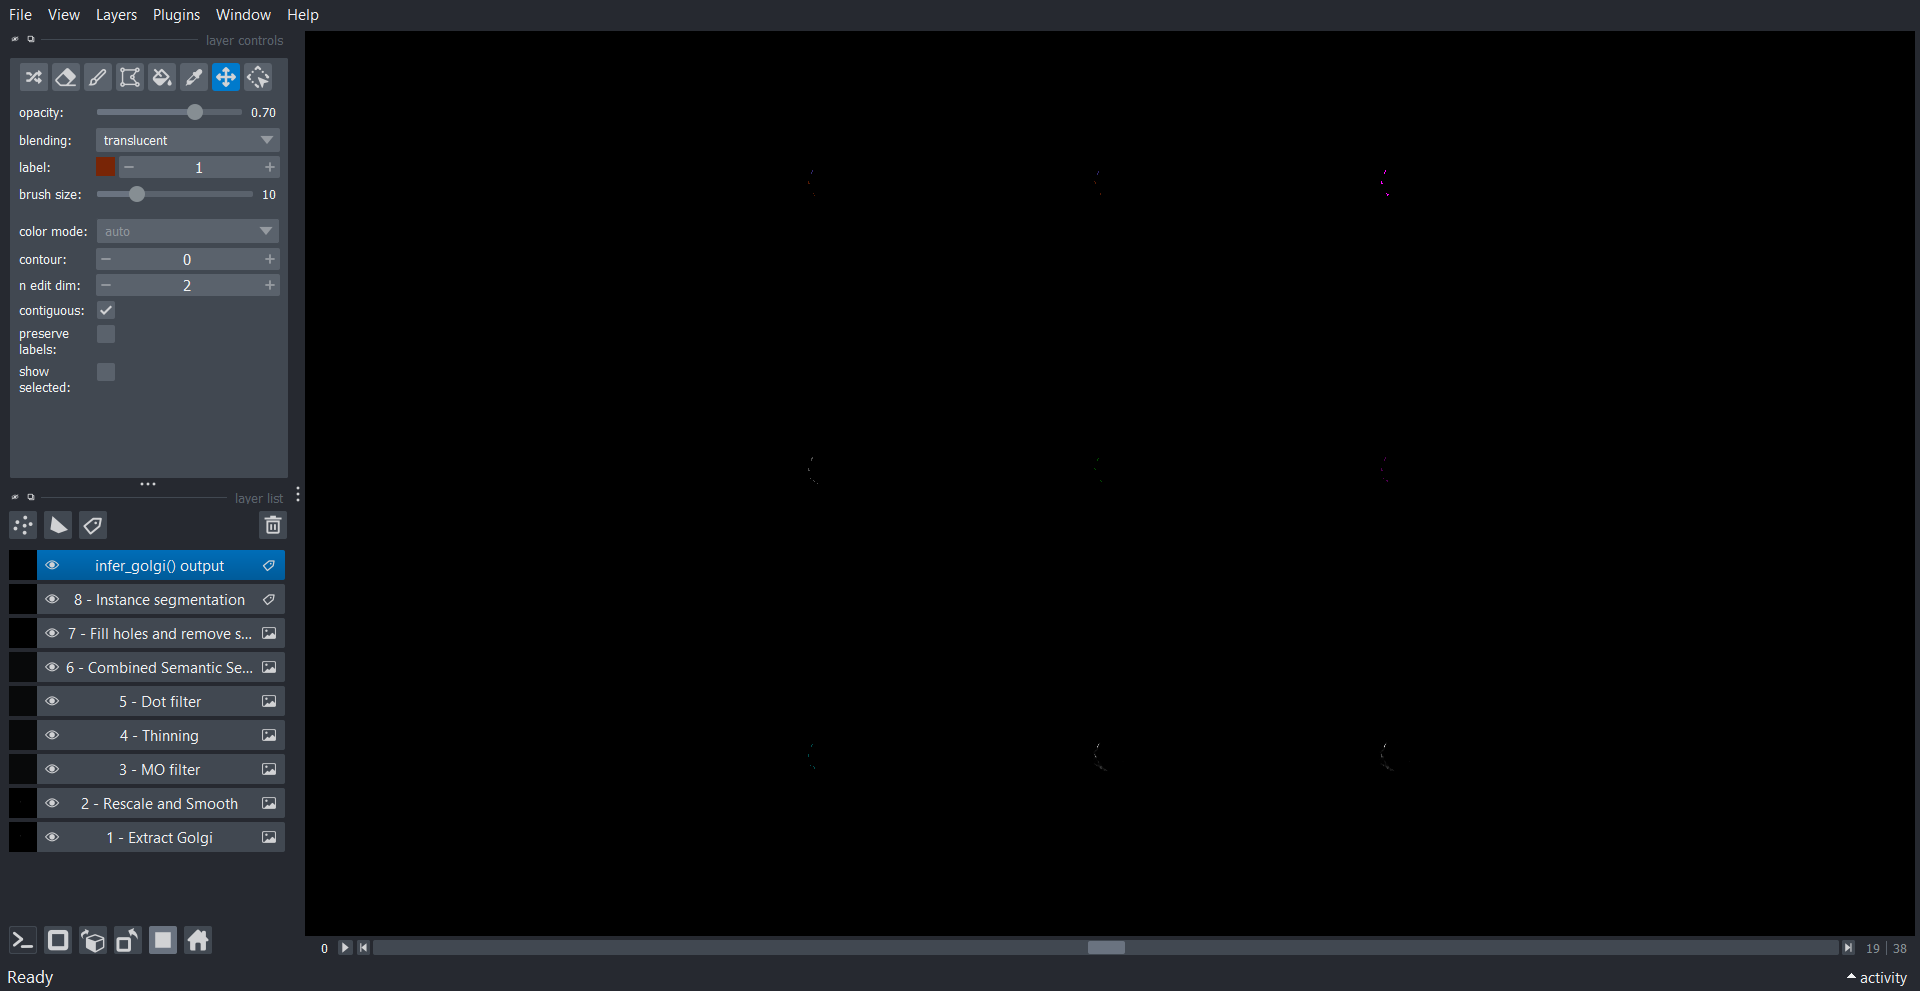

In [22]:
_golgi_object =  _infer_golgi(
    img_data,
    GOLGI_CH,
    median_sz,
    gauss_sig,
    thresh_method,
    thresh_adj,
    cell_wise_min_area,
    thin_dist_preserve,
    thin_dist,
    dot_scale_1,
    dot_cut_1,
    dot_scale_2,
    dot_cut_2,
    dot_scale_3,
    dot_cut_3,
    dot_method,
    hole_min_width,
    hole_max_width,
    small_object_width,
    fill_filter_method) 

#confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(golgi_labels == _golgi_object)}")

# adding image to Napari as a new layer
viewer.add_labels(_golgi_object, scale=scale, name="infer_golgi() output")
viewer.grid.enabled = True
viewer.reset_view()

# screenshot viewer
nbscreenshot(viewer, canvas_only = False)

-------------
### ✅ **INFER GOLGI COMPLETE!**

Continue on to other notebooks as needed:
- Infer [`lysosomes`](1.2_infer_lysosome.ipynb)
- Infer [`mitochondria`](1.3_infer_mitochondria.ipynb)
- Infer [`peroxisomes`](1.5_infer_peroxisome.ipynb)
- Infer [`endoplasmic reticulum (ER)`](1.6_infer_ER.ipynb)
- Infer [`lipid droplets`](1.7_infer_lipid_droplet.ipynb)

Or proceed to batch processing here: [batch process notebook](batch_process_segmentations.ipynb)